In [1]:
# Setup from initial notebook setup. Run once!

# Duckdb is a SQL engine that allows us to execute powerful, analytics-friendly
# queries against local or remote databases and flat files.
import duckdb
import pandas as pd

# Create a database file on disk
conn = duckdb.connect('example.db')
# Enable remote access
conn.sql("INSTALL httpfs")
conn.sql("LOAD httpfs")
# This database file points to files totaling multiple GBs,
# but it's only about 300KB itself. The `ATTACH` command
# gives us access to views that sit on top of remote Parquet files.
try:
  conn.sql("ATTACH 'https://data.baseball.computer/dbt/bc_remote.db' (READ_ONLY)")
except duckdb.BinderException:
  # This command will fail if you run it more than once because it already exists,
  # in which case we don't need to do anything
  pass

conn.sql("USE bc_remote")
conn.sql("USE main_models")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [2]:
# Matplotlib import for graphical analysis

import matplotlib.pyplot as plt
plt.close("all")

In [3]:
# Let's find the longest at-bats in history
df: pd.DataFrame = conn.sql("""
with longatbats as(
SELECT
    eps.event_key,
    ee.game_id,
    count(*) cou
FROM
    event.event_pitch_sequences eps
    join event.events ee
        on eps.event_key = ee.event_key
WHERE
    eps.sequence_item NOT LIKE '%Pickoff%'
GROUP BY
1,2
), longatbats_yr as (
select
    CAST(substr(ee.game_id,4,4) AS INTEGER) yr,
    avg(cou) pitchesperab
from
    longatbats
    join event.events ee
        on longatbats.event_key = ee.event_key
GROUP BY
    CAST(substr(ee.game_id,4,4) AS INTEGER)
ORDER BY
CAST(substr(ee.game_id,4,4) AS INTEGER) desc
)
SELECT
    *
FROM longatbats_yr


"""                           ).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,yr,pitchesperab
0,2023,3.391737
1,2022,3.787408
2,2021,3.804159
3,2020,3.840095
4,2019,3.831980
...,...,...
110,1913,2.964029
111,1912,2.965605
112,1911,3.019608
113,1910,2.997573


In [8]:
# Let's find the longest at-bats in history using recursion

longatbats = """
SELECT
            eps.event_key,
            ee.game_id,
            count(*) cou
        FROM
            event.event_pitch_sequences eps
            join event.events ee
                on eps.event_key = ee.event_key
        WHERE
            eps.sequence_item NOT LIKE '%Pickoff%'
        GROUP BY
            1,2 """

longatbats_yr = """
select
        CAST(substr(ee.game_id,4,4) AS INTEGER) yr,
        avg(cou) pitchesperab
    from (""" + longatbats + """)
        longatbats
    join event.events ee
        on longatbats.event_key = ee.event_key
GROUP BY
    CAST(substr(ee.game_id,4,4) AS INTEGER)
ORDER BY
CAST(substr(ee.game_id,4,4) AS INTEGER) desc
"""

longatbats_smoothed = """
SELECT
    yr,
    pitchesperab pitchesperabbase,
    pitchesperab avg_pitches
FROM (""" + longatbats_yr + """) longatbats_yr
WHERE
    yr=1909
UNION ALL
SELECT
    longatbats_smoothed.yr,
    longatbats_smoothed.pitchesperabbase pitchesperabbase,
    (longatbats_smoothed.pitchesperabbase + longatbats_lastyr.pitchesperab)/2 avg_pitches
FROM (""" + longatbats_yr + """) longatbats_lastyr
    JOIN longatbats_smoothed
        on longatbats_lastyr.yr - 1 = longatbats_smoothed.yr
WHERE
    longatbats_smoothed.yr>1900"""

longatbats_query = """
with recursive longatbats_smoothed as (""" + longatbats_smoothed + """)
SELECT
    *
FROM longatbats_smoothed"""
# print(longatbats_query)
df: pd.DataFrame = conn.sql(longatbats_query).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,yr,pitchesperabbase,avg_pitches


In [6]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='yr'>

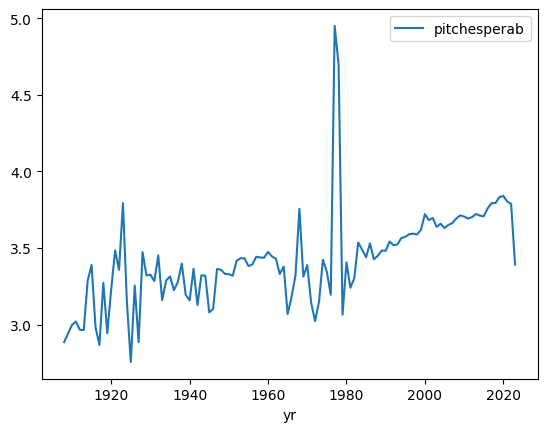

In [10]:
df.plot(x="yr", y="pitchesperab")